<a href="https://colab.research.google.com/github/jiheddachraoui/Frame-level-Scoring-of-Compressed-COVID-19-Ultrasound-Videos/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import The Required Libraries

In [77]:
# basics
import sys
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import cv2
import pickle 

import shutil
# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.keras.utils import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.regularizers import l2
from keras.models import Sequential , Functional
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.utils import  load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, roc_auc_score
import keras.backend
import os
import random
import time
import datetime
from tensorflow.python.framework import ops
import inspect
import gc

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## utility functions

In [78]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today() 

## code


In [79]:
batch_size =16
model_name="vgg16"
fold_name="fold1"
input_directory = "/content/gdrive/MyDrive/Dataset/data_{}/".format(fold_name)
output_directory = "/content/gdrive/MyDrive/Dataset/output/"

train_path = input_directory + r"train"
val_path = input_directory + r"valid"
test_path = input_directory + r"test"

figure_directory = "output/figures" 
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"




### preprosessing

In [80]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value

random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
#tf.set_random_seed(seed_value)
tf.random.set_seed(seed_value)
# 5. For layers that introduce randomness like dropout, make sure to set seed values 
#model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [81]:
datagen = ImageDataGenerator( rescale=1.0/255.0,
                                   shear_range = 0.02,
                                   zoom_range = 0.02, rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    
    width_shift_range=0.1,
    height_shift_range=0.1)



train_generator = datagen.flow_from_directory(directory = train_path, 
                                                    color_mode="rgb",
                                                    target_size = (240, 240), # image height , image width
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=42)
'''val_generator = datagen.flow_from_directory(directory = val_path, 
                                                 color_mode="rgb",
                                                    target_size = (333,666), # image height , image width
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=42)'''
test_generator = datagen.flow_from_directory(directory = test_path, 
                                                 color_mode="rgb",
                                                    target_size = (240, 240), # image height , image width
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=42)

test_generator.reset()

Found 180 images belonging to 4 classes.
Found 66 images belonging to 4 classes.


In [82]:
x,y = next(train_generator)
x.shape

(16, 240, 240, 3)

In [83]:
"""a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list
 
 
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(batch_size):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
 
plot_images(x,y)"""

"a = train_generator.class_indices\nclass_names = list(a.keys())  # storing class/breed names in a list\n \n \ndef plot_images(img, labels):\n    plt.figure(figsize=[15, 10])\n    for i in range(batch_size):\n        plt.subplot(5, 5, i+1)\n        plt.imshow(img[i])\n        plt.title(class_names[np.argmax(labels[i])])\n        plt.axis('off')\n \nplot_images(x,y)"

# Fine tuning

In [84]:
# Load pre-trained model
base_model= tf.keras.models.load_model('/content/gdrive/MyDrive/Dataset/output/models/Model_frame_{}.h5'.format(model_name))
model = Sequential()

for layer in base_model.layers[:-1]: # this is where I changed your code
    model.add(layer)  

# Freeze the layers of the base model
for layer in model.layers:
    layer.trainable = False
base_model=model

# add new layers to the base model
x = base_model.output
#x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
predictions = keras.layers.Dense(4, activation='softmax')(x)

# create a new model with the new layers
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

In [85]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True,
                                         #monitor='loss', 
                                         #mode='min'
)
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=r"/content/gdrive/MyDrive/Dataset/output/checkpoints/model_tuned_"+model_name+"_"+fold_name+"_{epoch}.h5",
   save_best_only=True,
    verbose=1,
    #monitor='loss', 
    #mode='min'

)
reduce1=tf.keras.callbacks.ReduceLROnPlateau(patience=10,
                                             #monitor='loss', 
                                             #mode='min',  # after 10 epochs with no improvement
    verbose=1)
callbacks=[early,checkpoint,reduce1]
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.0001),loss='categorical_crossentropy',metrics=[AUC()])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_input (InputLayer)    [(None, 240, 240, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 1024)              263168    
                                                                 
 dense_13 (Dense)            (None, 256)               2624

In [86]:
#model=tf.keras.models.load_model("/content/gdrive/MyDrive/Dataset/output/checkpoints/model_tuned_vgg16_fold3_19.h5")


In [87]:
epochs=100
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

print("start Model Trainning", date_time(1))
# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=callbacks)


print("Completed Model Trainning", date_time(1))

start Model Trainning Timestamp: 2023-01-31 00:21:22
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.3516 - auc_4: 0.6139
Epoch 1: val_loss improved from inf to 1.40704, saving model to /content/gdrive/MyDrive/Dataset/output/checkpoints/model_tuned_vgg16_fold1_1.h5
11/11 [==============================] - 152s 14s/step - loss: 1.3516 - auc_4: 0.6139 - val_loss: 1.4070 - val_auc_4: 0.4477 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 1.3019 - auc_4: 0.6680 
Epoch 2: val_loss improved from 1.40704 to 1.40391, saving model to /content/gdrive/MyDrive/Dataset/output/checkpoints/model_tuned_vgg16_fold1_2.h5
11/11 [==============================] - 148s 14s/step - loss: 1.3019 - auc_4: 0.6680 - val_loss: 1.4039 - val_auc_4: 0.4555 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 1.2630 - auc_4: 0.6978
Epoch 3: val_loss did not improve from 1.40391
11/11 [==============================] - 148s 1

In [88]:
model.save("/content/gdrive/MyDrive/Dataset/output/models/model_tuned_"+model_name+"_{}.h5".format(fold_name))

## Visualization

In [89]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    #print(list(cnn_model.history.keys()))
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[1]
    val_auc_name = list(cnn_model.history.keys())[3]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps = len(test_generator))
    print(y_true)
    print(Y_pred)
   
   
    #y_pred = (Y_pred > 0.5).T[0]
    y_pred = np.argmax(Y_pred, axis=1)
    print(y_pred)
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred,labels=[0,1,2,3])
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    #print(counts)
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [[f'{names[i]}\n{percentages[i]}' for i in range(len(names))] for j in range(len(cm))]
    #print(labels)
    #labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['socre0', 'socre1','socre2','socre3']
    #print(cm)
    #print(labels)
    # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=True, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    plt.savefig("/content/gdrive/MyDrive/Dataset/output/figures/cm_model_tuned_"+model_name+"_{}.jpg".format(fold_name))
    
  
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout();
    
    ## Summary Statistics
    
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    precision = np.mean(precision)  
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    recall = np.mean(recall)
    f1 = 2 * (precision * recall) / (precision + recall)
    TN = np.sum(np.diag(cm)) - np.sum(cm)
    FP = np.sum(cm, axis=0) - np.diag(cm)
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    specificity = np.mean(specificity)
    
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

5/5 [==============================] - 42s 8s/step
[0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[[0.24449372 0.22252685 0.34021    0.19276942]
 [0.22623609 0.22837521 0.35611102 0.1892777 ]
 [0.24708912 0.2224715  0.3502042  0.18023513]
 [0.23886633 0.22526743 0.35251004 0.18335621]
 [0.22642684 0.2275158  0.3584959  0.1875616 ]
 [0.23922744 0.22384304 0.34984767 0.18708175]
 [0.23957992 0.22369996 0.34412253 0.19259761]
 [0.23746619 0.22378007 0.34382564 0.19492814]
 [0.22789305 0.22934616 0.3530397  0.18972103]
 [0.24815117 0.22295538 0.35505012 0.17384328]
 [0.22680637 0.22788063 0.35803103 0.18728203]
 [0.22597142 0.2270921  0.35982972 0.18710676]
 [0.22862868 0.23023136 0.3475487  0.19359131]
 [0.22872804 0.22931774 0.34982285 0.19213139]
 [0.24611418 0.22715956 0.33786288 0.18886344]
 [0.22761531 0.22881842 0.3532347  0.19033143]
 [0.22797506 0.22798944 0.35509345 0.18894212]
 [0.22893253 0.

<ipython-input-89-ae5451aa6547>:77: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diag(cm) / np.sum(cm, axis = 0)
<ipython-input-89-ae5451aa6547>:84: RuntimeWarning: divide by zero encountered in true_divide
  specificity = TN / (TN+FP) # % negative out of all supposed to be negatives


[Summary Statistics]
Accuracy = 40.91% | Precision = nan% | Recall = 25.00% | Specificity = -inf% | F1 Score = nan%


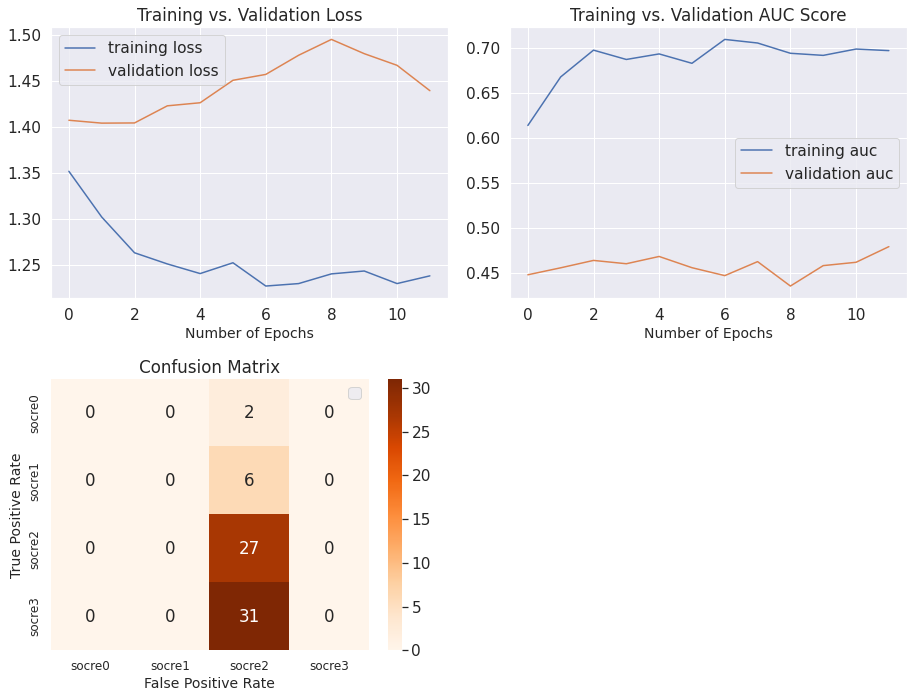

In [90]:
create_charts(model, history)

In [91]:
"""# store results
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
 
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')"""

"# store results\nacc = history.history['auc']\nval_acc = history.history['val_auc']\nloss = history.history['loss']\nval_loss = history.history['val_loss']\n \n \n# plot results\n# accuracy\nplt.figure(figsize=(10, 16))\nplt.rcParams['figure.figsize'] = [16, 9]\nplt.rcParams['font.size'] = 14\nplt.rcParams['axes.grid'] = True\nplt.rcParams['figure.facecolor'] = 'white'\nplt.subplot(2, 1, 1)\nplt.plot(acc, label='Training Accuracy')\nplt.plot(val_acc, label='Validation Accuracy')\nplt.legend(loc='lower right')\nplt.ylabel('Accuracy')\nplt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')"

In [92]:
"""# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()"""

"# loss\nplt.subplot(2, 1, 2)\nplt.plot(loss, label='Training Loss')\nplt.plot(val_loss, label='Validation Loss')\nplt.legend(loc='upper right')\nplt.ylabel('Cross Entropy')\nplt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')\nplt.xlabel('epoch')\nplt.tight_layout(pad=3.0)\nplt.show()"

In [93]:
accuracy_score = model.evaluate(test_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

5/5 [==============================] - 42s 8s/step - loss: 1.4035 - auc_4: 0.4435
[1.4035300016403198, 0.44348788261413574]
Accuracy: 44.3488%
Loss:  1.4035300016403198
